In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [53]:
! rm -r '/kaggle/working/Split'

In [1]:
import os

In [33]:
!pip install split-folders

In [54]:
import splitfolders

input_folder = r'/kaggle/input/multiple-skin-disease-detection-and-classification/Skin Cancer Dataset'

# Split with a ratio
# To only split into training and validation set, set a tuple to ratio, i.e; 80/20
#Train, val, test
splitfolders.ratio(input_folder, output=r'/kaggle/working/Split', 
                   seed=42, ratio=(.7, .2, .1), 
                   group_prefix=None) # default values

Copying files: 4109 files [00:11, 370.16 files/s]


In [2]:
train_dir = '/kaggle/working/Split/train'
val_dir = '/kaggle/working/Split/val'
test_dir = '/kaggle/working/Split/test'
batch_size = 32

In [37]:
from tqdm import tqdm
import cv2
import albumentations as A

/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.2 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [56]:
augmentation_pipeline = A.Compose([
    A.Rotate(limit=(-30, 30), p=1),  # Random rotation within the range -20° to 20°
    A.HorizontalFlip(p=0.7),        # 50% chance of flipping the image horizontally
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=1),  # Random brightness/contrast changes
    A.GaussianBlur(blur_limit=(3, 7), p=1)  # Random blur with kernel size between 3x3 and 7x7
])


# Paths
input_folder = train_dir
output_folder = train_dir
os.makedirs(output_folder, exist_ok=True)

# Loop through classes
for class_name in os.listdir(input_folder):
    class_input_path = os.path.join(input_folder, class_name)
    class_output_path = os.path.join(output_folder, class_name)
    os.makedirs(class_output_path, exist_ok=True)

    for image_name in tqdm(os.listdir(class_input_path), desc=f"Processing {class_name}"):
        image_path = os.path.join(class_input_path, image_name)
        if not os.path.exists(image_path):
            print(f"File not found: {image_path}")
            continue
        image = cv2.imread(image_path)
        if image is None:
            print(f"Failed to read image: {image_path}")
            continue
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
    # Apply augmentation
        augmented_image = augmentation_pipeline(image=image)["image"]
        
        # Save augmented image
        save_path = os.path.join(class_output_path, f"aug_{image_name}.jpg")
        cv2.imwrite(save_path, cv2.cvtColor(augmented_image, cv2.COLOR_RGB2BGR))

Processing Vascular Lesion: 100%|██████████| 203/203 [00:07<00:00, 28.30it/s]


Failed to read image: /kaggle/working/Split/train/Vascular Lesion/metadata.csv


Processing Melanoma: 100%|██████████| 353/353 [00:26<00:00, 13.46it/s]


In [3]:
len(os.listdir('/kaggle/working/Split/train/Acitinic Keratosis'))

700

In [4]:
import matplotlib.pyplot as plt

In [5]:
def plot_history(history):
    fig, ax = plt.subplots(1, 2, figsize=(15,5))
    ax[0].set_title('loss')
    ax[0].plot(history.epoch, history.history["loss"], label="Train loss")
    ax[0].plot(history.epoch, history.history["val_loss"], label="Validation loss")
    ax[1].set_title('accuracy')
    ax[1].plot(history.epoch, history.history["accuracy"], label="Train acc")
    ax[1].plot(history.epoch, history.history["val_accuracy"], label="Validation acc")
    ax[0].legend()
    ax[1].legend()
    ax[0].set_ylim(0, 3)
    ax[1].set_ylim(0, 1)

In [6]:
from tensorflow.keras.utils import image_dataset_from_directory # type: ignore

def load_data(data_dir: str):

    ds = image_dataset_from_directory(
    data_dir,
    labels="inferred",
    label_mode="categorical",
    seed=123,
    image_size=(224,224),
    batch_size=batch_size)

    return ds

In [7]:
train_ds = load_data(train_dir)
val_ds = load_data(val_dir)
test_ds = load_data(test_dir)

Found 5748 files belonging to 9 classes.
Found 820 files belonging to 9 classes.
Found 413 files belonging to 9 classes.


In [8]:
class_weights_dict = {1: 0.9131111111111111,
                      2: 0.9131111111111111,
                      3: 1.1413888888888888,
                      4: 0.9040704070407041,
                      5: 0.9131111111111111,
                      6: 0.9131111111111111,
                      7: 0.9131111111111111,
                      8: 1.1027911969940956,
                      9: 1.5743295019157089}

In [9]:
import tensorflow as tf
from tensorflow.keras import Model, layers, optimizers, callbacks
from tensorflow.keras.applications import ResNet101, VGG19, ResNet50
from tensorflow.keras.regularizers import l1,l2,l1_l2
from tensorflow.keras.applications.resnet import preprocess_input as respreproc

In [25]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [23]:
def generate_confusion_matrix(model, test_dataset):
    # Extract true labels and predicted labels
    y_true = []
    y_pred = []

    for images, labels in test_dataset:
        # Get model predictions
        predictions = model.predict(images)
        predicted_classes = np.argmax(predictions, axis=1)
        true_classes = np.argmax(labels.numpy(), axis=1)

        y_true.extend(true_classes)
        y_pred.extend(predicted_classes)

    # Create confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    classes = test_dataset.class_names  # Class names from the dataset
    
    # Display the confusion matrix
    plt.figure(figsize=(12, 10))  # Adjust the figure size here
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    disp.plot(cmap=plt.cm.Blues, ax=plt.gca())
    
    # Customize label font size for better readability
    plt.xticks(rotation=80, fontsize=12)  # Rotate x-axis labels and increase font size
    plt.yticks(fontsize=12)               # Increase y-axis label font size
    plt.title("Confusion Matrix", fontsize=16)
    plt.show()

    report = classification_report(y_true, y_pred, target_names=classes, output_dict=True)
    df_report = pd.DataFrame(report).transpose()

 # Display the table with metrics
    print("Classification Metrics:")
    display(df_report.style.set_caption("Classification Metrics by Class").format("{:.2f}"))


# Trying with ConvNeXtLarge


In [11]:
from tensorflow.keras.applications import ConvNeXtLarge
from tensorflow.keras.applications.convnext import preprocess_input as convnextpreproc

In [19]:
base_model = ConvNeXtLarge(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
#base_model.trainable = False  # Freeze the base model

base_model.trainable = True
# You can unfreeze only the last few layers, like:
for layer in base_model.layers[:-10]:  # Keep the first few layers frozen
    layer.trainable = False

inputs = layers.Input(shape=(224, 224, 3))
x = convnextpreproc(inputs)
x = base_model(x) 

# Add custom layers
x = layers.GlobalAveragePooling2D()(x)

x = layers.Dense(32, kernel_initializer="he_normal", kernel_regularizer=l1_l2(l1=0.2, l2=0.01))(x)
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)
x = layers.Dropout(0.6)(x)
pred = layers.Dense(9, activation="softmax")(x)

# Define the model
model_convnext = Model(inputs=inputs, outputs=pred)

# Model summary
model_convnext.summary()

Model: "functional_40"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_29 (InputLayer)          │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ convnext_large (Functional)          │ (None, 7, 7, 1536)          │     196,230,336 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_4           │ (None, 1536)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 32)                  │          49,184 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 32)                  │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_4 (Activation)            │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 9)                   │             297 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 196,279,945 (748.75 MB)

 Trainable params: 19,017,609 (72.55 MB)

 Non-trainable params: 177,262,336 (676.20 MB)

In [20]:
# Compile the model
adam = optimizers.Adam(learning_rate=1e-3)
model_convnext.compile(loss='categorical_crossentropy',
                   optimizer=adam,
                   metrics=['accuracy'])

MODEL = "model_convnext.keras"

modelCheckpoint = callbacks.ModelCheckpoint(MODEL,
                                            monitor="val_loss",
                                            verbose=0,
                                            save_best_only=True)

def step_decay(epoch, lr):
    if epoch % 3 == 0 and epoch > 0 and epoch<=9:  # Decrease LR every 5 epochs
        return lr * 0.1
    return lr

LRreducer = callbacks.LearningRateScheduler(step_decay, verbose=1)

EarlyStopper = callbacks.EarlyStopping(monitor='val_loss',
                                       patience=10,
                                       verbose=0,
                                       restore_best_weights=True)

# Train the model
history_convnext = model_convnext.fit(
        train_ds,
        epochs=12,
        validation_data=val_ds,
        callbacks=[modelCheckpoint, LRreducer, EarlyStopper],
        class_weight=class_weights_dict)


Epoch 1: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 1/12
180/180 ━━━━━━━━━━━━━━━━━━━━ 122s 543ms/step - accuracy: 0.3212 - loss: 107.3731 - val_accuracy: 0.4695 - val_loss: 4.7093 - learning_rate: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/12
180/180 ━━━━━━━━━━━━━━━━━━━━ 83s 461ms/step - accuracy: 0.5271 - loss: 3.8086 - val_accuracy: 0.7134 - val_loss: 4.0237 - learning_rate: 0.0010

Epoch 3: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 3/12
180/180 ━━━━━━━━━━━━━━━━━━━━ 83s 462ms/step - accuracy: 0.6470 - loss: 3.4220 - val_accuracy: 0.7134 - val_loss: 3.1000 - learning_rate: 0.0010

Epoch 4: LearningRateScheduler setting learning rate to 0.00010000000474974513.
Epoch 4/12
180/180 ━━━━━━━━━━━━━━━━━━━━ 83s 462ms/step - accuracy: 0.7305 - loss: 1.5544 - val_accuracy: 0.7585 - val_loss: 1.1942 - learning_rate: 1.0000e-04

Epoch 5: LearningRateScheduler setting learning rat

In [97]:
from tensorflow.keras.models import load_model

In [21]:
model_convnext.evaluate(test_ds)

13/13 ━━━━━━━━━━━━━━━━━━━━ 9s 727ms/step - accuracy: 0.7727 - loss: 0.8878


[0.9428290724754333, 0.7457627058029175]

In [150]:
model_convnext.save('model_77.keras')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


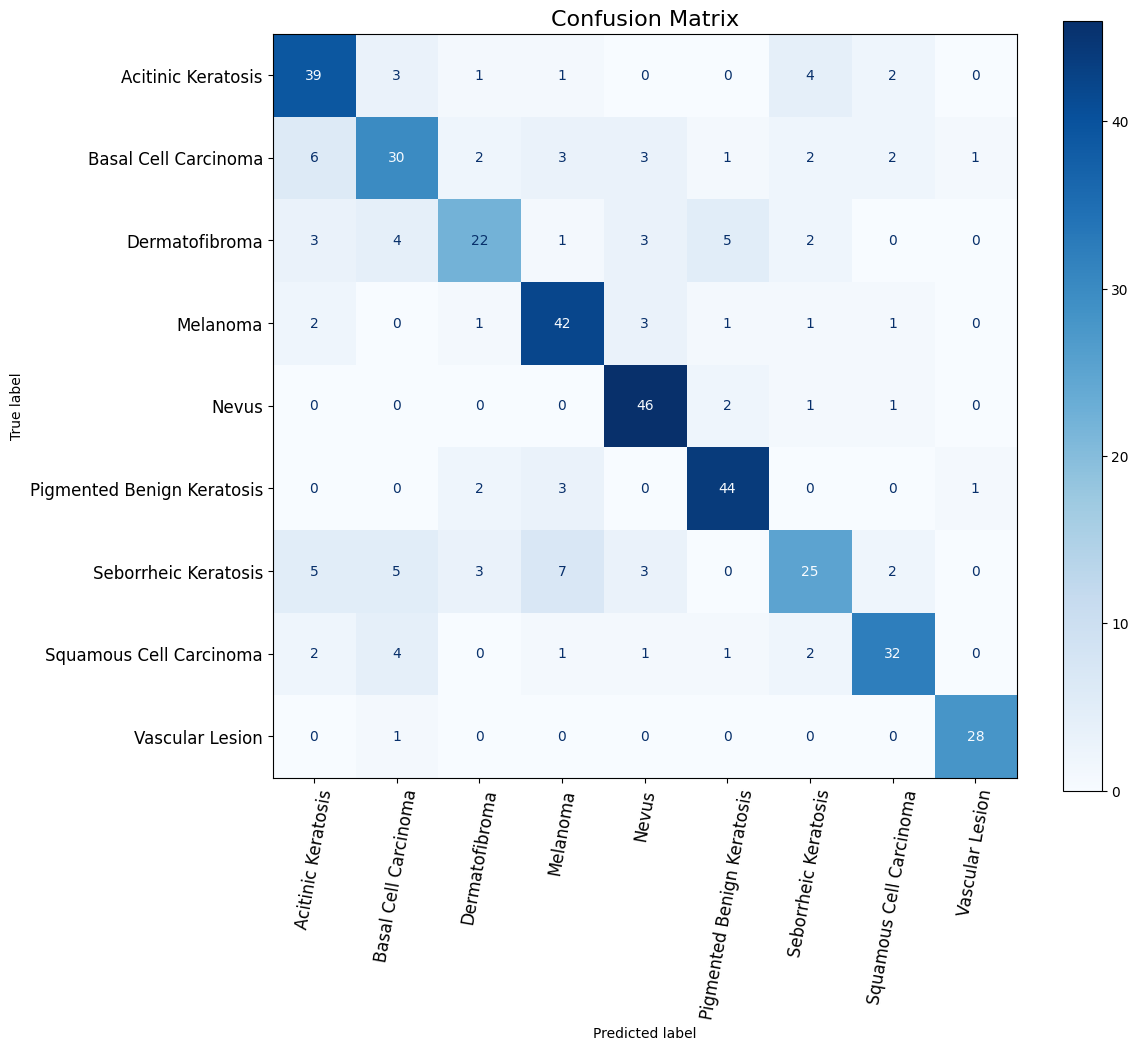

Classification Metrics:


,precision,recall,f1-score,support
Acitinic Keratosis,0.68,0.78,0.73,50.00
Basal Cell Carcinoma,0.64,0.60,0.62,50.00
Dermatofibroma,0.71,0.55,0.62,40.00
Melanoma,0.72,0.82,0.77,51.00
Nevus,0.78,0.92,0.84,50.00
Pigmented Benign Keratosis,0.81,0.88,0.85,50.00
Seborrheic Keratosis,0.68,0.50,0.57,50.00
Squamous Cell Carcinoma,0.80,0.74,0.77,43.00
Vascular Lesion,0.93,0.97,0.95,29.00
accuracy,0.75,0.75,0.75,0.75


In [26]:
generate_confusion_matrix(model_convnext, test_ds)

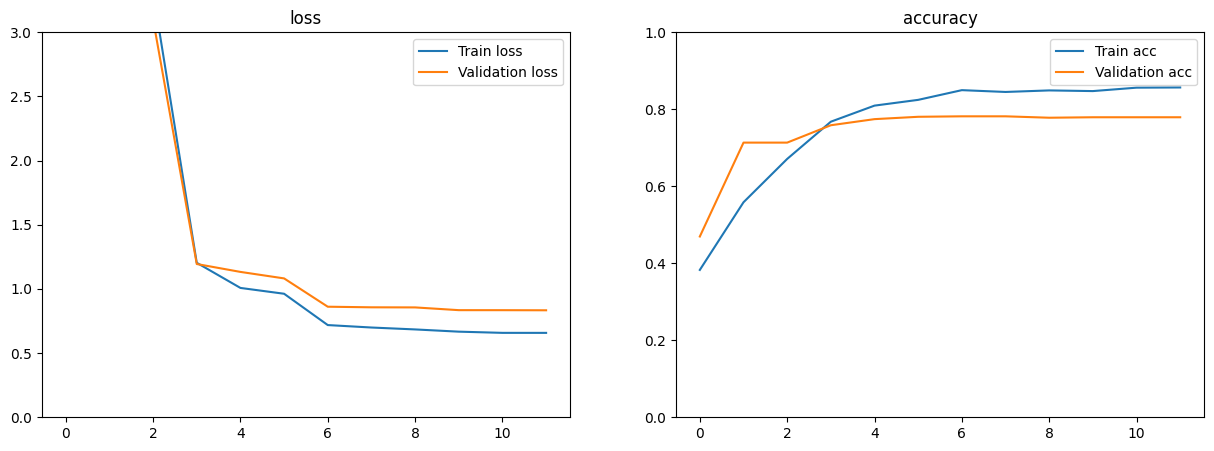

In [27]:
plot_history(history_convnext)